# **CNN Registration**

<div>
<img src="https://github.com/yzhq97/cnn-registration/raw/publish/img/process_comp.jpg" width="800"/>
</div>

### **Multi-temporal Remote Sensing Image Registration Using Deep Convolutional Features**


Yang, Z., Dan, T., & Yang, Y. (2018). Multi-temporal remote sensing image registration using deep convolutional features. Ieee Access, 6, 38544-38555.
[DOI](https://doi.org/10.1109/ACCESS.2018.2853100)


<a href="https://githubtocolab.com/giswqs/mberkay0/cnn-registration-with-regnet/blob/publish/cnn_registration_with_regnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

🌀 Clone the repository.

In [ ]:
!git clone https://github.com/yzhq97/cnn-registration.git

Cloning into 'cnn-registration'...
remote: Enumerating objects: 254, done.
remote: Total 254 (delta 0), reused 0 (delta 0), pack-reused 254
Receiving objects: 100% (254/254), 36.48 MiB | 20.91 MiB/s, done.
Resolving deltas: 100% (128/128), done.


❗ Do not forget to restart the runtime.

In [ ]:
%%capture
!pip install lap
!pip install timm
!pip install tensorflow==1.14.0

##**Utils**

In [ ]:
from __future__ import print_function
import torch
import torchvision.transforms as transforms
import timm
import time
import numpy as np
from math import exp, log
from scipy.interpolate import Rbf
import math

import matplotlib.pyplot as plt
import cv2
from PIL import Image
import inspect
import os
import time
import gc
from lap import lapjv
import timeit
import warnings
warnings.filterwarnings('ignore')



def gaussian_kernel(size, sigma=1.2):
    seq = np.array([[i, j] for i in range(size) for j in range(size)], dtype='int32')
    points = np.array(seq, dtype='float32') + 0.5
    center = np.array([0.5 * size, 0.5 * size])
    d = np.linalg.norm(points-center, axis=1)
    kern1d = 1.0/(sigma * (2*np.pi)**0.5) * np.exp(-1.0 * np.power(d, 2) / (2.0 * sigma**2))
    kern = kern1d.reshape([size, size]) / np.sum(kern1d)
    return kern

def pairwise_distance(X, Y):
    assert len(X.shape) == len(Y.shape)
    N = X.shape[0]
    M = Y.shape[0]
    # D = len(X.shape)
    res = np.zeros([M, N])
    for i in range(M):
        for j in range(N):
            res[i][j] = np.linalg.norm(X[j] - Y[i])
    return res
    # return np.linalg.norm(
    #     np.repeat(np.expand_dims(X, axis=0), M, axis=0) -
    #     np.repeat(np.expand_dims(Y, axis=1), N, axis=1),
    #     axis=D)

def gaussian_radial_basis(X, beta=2.0):
    PD = pairwise_distance(X, X)
    return np.exp(-0.5 * np.power(PD/beta, 2))

def init_sigma2(X, Y):
    N = float(X.shape[0])
    M = float(Y.shape[0])
    t1 = M * np.trace(np.dot(np.transpose(X), X))
    t2 = N * np.trace(np.dot(np.transpose(Y), Y))
    t3 = 2.0 * np.dot(np.sum(X, axis=0), np.transpose(np.sum(Y, axis=0)))
    return (t1 + t2 -t3)/(M*N*2.0)

def match(PD):
    seq = np.arange(PD.shape[0])
    amin1 = np.argmin(PD, axis=1)
    C = np.array([seq, amin1]).transpose()
    min1 = PD[seq, amin1]
    mask = np.zeros_like(PD)
    mask[seq, amin1] = 1
    masked = np.ma.masked_array(PD, mask)
    min2 = np.amin(masked, axis=1)
    return C, np.array(min2/min1)

def match_max(PD):
    seq = np.arange(PD.shape[0])
    amax1 = np.argmin(PD, axis=1)
    C = np.array([seq, amax1]).transpose()
    return C

def compute(X, Y, T_old, Pm, sigma2, omega):
    N = X.shape[0]
    M = Y.shape[0]
    T = T_old

    Te = np.repeat(np.expand_dims(T, axis=1), N, axis=1)
    Xe = np.repeat(np.expand_dims(T, axis=0), M, axis=0)
    Pmxn = (1-omega) * Pm * np.exp(
        -(1 / (2 * sigma2)) * np.sum(np.power(Xe-Te, 2), axis=2) )

    Pxn = np.sum(Pmxn, axis=0) + omega/N
    Po = Pmxn / np.repeat(np.expand_dims(Pxn, axis=0), M, axis=0)

    Np = np.dot(np.dot(np.ones([1, M]), Po), np.ones([N, 1]))[0, 0]
    P1 = np.squeeze(np.dot(Po, np.ones([N, 1])))
    Px = np.diag(np.squeeze(np.dot(Po.transpose(), np.ones([M, 1]))))
    Py = np.diag(P1)
    t1 = np.trace(np.dot(np.dot(X.transpose(), Px), X))
    t2 = np.trace(np.dot(np.dot(T.transpose(), Po), X))
    t3 = np.trace(np.dot(np.dot(T.transpose(), Py), T))
    tmp =  t1 - 2.0*t2 + t3
    Q = Np * log(sigma2) + tmp/(2.0*sigma2)
    return Po, P1, Np, tmp, Q

def pd_expand(PD, k):
    N0 = np.int(np.sqrt(PD.shape[0]))
    N1 = k*N0
    L0, L1 = N0**2, N1**2
    Cmat = np.kron(np.arange(L0).reshape([N0, N0]), np.ones([k, k], dtype='int32'))
    i = np.repeat(Cmat.reshape([L1, 1]), L1, axis=1)
    j = np.repeat(Cmat.reshape([1, L1]), L1, axis=0)
    return PD[i, j]

def tps_warp(Y, T, Y_image, out_shape):
    Y_height, Y_width = Y_image.shape[:2]
    T_height, T_width = out_shape[:2]

    i_func = Rbf(T[:, 0], T[:, 1], Y[:, 0], function='thin-plate')
    j_func = Rbf(T[:, 0], T[:, 1], Y[:, 1], function='thin-plate')

    iT, jT = np.mgrid[:T_height, :T_width]
    iT = iT.flatten()
    jT = jT.flatten()
    iY = np.int_(i_func(iT, jT))
    jY = np.int_(j_func(iT, jT))

    keep = np.logical_and(iY>=0, jY>=0)
    keep = np.logical_and(keep, iY<Y_height)
    keep = np.logical_and(keep, jY<Y_width)
    iY, jY, iT, jT = iY[keep], jY[keep], iT[keep], jT[keep]

    out_image = np.zeros(out_shape, dtype='uint8')
    out_image[iT, jT, :] = Y_image[iY, jY, :]

    return out_image

def checkboard(I1, I2, n=7):
    assert I1.shape == I2.shape
    height, width, channels = I1.shape
    hi, wi = height/n, width/n
    print("hi =",hi,", wi =", wi)
    outshape = (int(hi*n), int(wi*n), channels)
    print("outshape =", outshape)
    out_image = np.zeros(outshape, dtype='uint8')
    for i in range(n):
        h = int(hi * i)
        h1 = int(h + hi)
        for j in range(n):
            w = int(wi * j)
            w1 = int(w + wi)
            if (i-j)%2 == 0:
                out_image[h:h1, w:w1, :] = I1[h:h1, w:w1, :]
            else:
                out_image[h:h1, w:w1, :] = I2[h:h1, w:w1, :]

    return out_image

def overlap(background, overlay, alpha):
    overlapped = Image.blend(
        Image.fromarray(background), 
        Image.fromarray(overlay), 
        alpha)
    
    return np.asarray(overlapped)


In [ ]:
try:
    xrange           # Python 2
except NameError:
    xrange = range   # Python 3, xrange is now named range

def logspace(d1, d2, n):
    sp = np.zeros(n)
    k = np.arange(n-1)
    sp[:n-1] = 10 ** (d1 + k * (d2 - d1) / (n - 1))
    sp[n-1] = 10 ** d2
    return sp

def get_angle(p1, p2):
    """Return angle in radians"""
    return math.atan2((p2[1] - p1[1]), (p2[0] - p1[0]))


class ShapeContext(object):
    HUNGURIAN = 1

    def __init__(self, nbins_r=5, nbins_theta=12, r_inner=0.1250, r_outer=2.0):
        self.nbins_r = nbins_r
        self.nbins_theta = nbins_theta
        self.r_inner = r_inner
        self.r_outer = r_outer
        self.nbins = nbins_theta * nbins_r

    def _dist2(self, x, c):
        result = np.zeros((N, len(c)))
        for i in xrange(N):
            for j in xrange(len(c)):
                result[i, j] = euclid_distance(x[i], c[j])
        return result

    def _get_angles(self, x):
        N = len(x)
        result = np.zeros((N, N))
        for i in xrange(N):
            for j in xrange(N):
                result[i, j] = get_angle(x[i], x[j])
        return result

    def get_mean(self, matrix):
        """ This is not working. Should delete this and make something better"""
        h, w = matrix.shape
        mean_vector = matrix.mean(1)
        mean = mean_vector.mean()

        return mean

    def compute(self, X, r=None):
        N = len(X)

        r_array = pairwise_distance(X, X)
        mean_dist = r_array.mean()
        r_array_n = r_array / mean_dist

        r_bin_edges = logspace(np.log10(self.r_inner), np.log10(self.r_outer), self.nbins_r)

        r_array_q = np.zeros((N, N), dtype=int)
        for m in xrange(self.nbins_r):
            
            r_array_q += (r_array_n < r_bin_edges[m])

        fz = r_array_q > 0

        theta_array = self._get_angles(X)
        # 2Pi shifted
        theta_array_2 = theta_array + 2 * math.pi * (theta_array < 0)
        theta_array_q = np.int_(1 + np.floor(theta_array_2 / (2 * math.pi / self.nbins_theta)))
        # norming by mass(mean) angle v.0.1 ############################################
        # By Andrey Nikishaev
        # theta_array_delta = theta_array - theta_array.mean()
        # theta_array_delta_2 = theta_array_delta + 2*math.pi * (theta_array_delta < 0)
        # theta_array_q = 1 + floor(theta_array_delta_2 /(2 * math.pi / self.nbins_theta))
        ################################################################################

        BH = np.zeros((N, self.nbins))
        for i in xrange(N):
            sn = np.zeros((self.nbins_r, self.nbins_theta))
            for j in xrange(N):
                if (fz[i, j]):
                    sn[r_array_q[i, j] - 1, theta_array_q[i, j] - 1] += 1
            BH[i] = sn.reshape(self.nbins)

        return BH

    def _cost(self, hi, hj):
        cost = 0
        for k in xrange(self.nbins):
            if (hi[k] + hj[k]):
                cost += ((hi[k] - hj[k]) ** 2) / (hi[k] + hj[k])

        return cost * 0.5

    def cost(self, P, Q, qlength=None):
        p, _ = P.shape
        p2, _ = Q.shape
        d = p2
        if qlength:
            d = qlength
        C = np.zeros((p, p2))
        for i in xrange(p):
            for j in xrange(p2):
                C[i, j] = self._cost(Q[j] / d, P[i] / p)

        return C

        return result

## **The method in the article**

### **VGG16**

In [ ]:
import tensorflow as tf

VGG_MEAN = [103.939, 116.779, 123.68]


class VGG16mo:
    def __init__(self, vgg16_npy_path=None):
        if vgg16_npy_path is None:
            """
            path = inspect.getfile(VGG16mo)
            path = os.path.abspath(os.path.join(path, os.pardir))
            path = os.path.join(path, "vgg16partial.npy")
            vgg16_npy_path = path
            """
            vgg16_npy_path = '/content/cnn-registration/src/vgg16partial.npy'

        self.data_dict = np.load(vgg16_npy_path, encoding='latin1',allow_pickle=True).item()

    def build(self, bgr):
        blue, green, red = tf.split(axis=3, num_or_size_splits=3, value=bgr)
        assert red.get_shape().as_list()[1:] == [224, 224, 1]
        assert green.get_shape().as_list()[1:] == [224, 224, 1]
        assert blue.get_shape().as_list()[1:] == [224, 224, 1]
        bgr = tf.concat(axis=3, values=[
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ])
        assert bgr.get_shape().as_list()[1:] == [224, 224, 3]

        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.pool3 = self.max_pool(self.conv3_3, 'pool3')
        self.pool3_1_s4 = self.max_pool_s4(self.conv3_1, 'pool3_1_s4')
        self.pool3_s4 = self.max_pool_s4(self.conv3_3, 'pool3_s4')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.pool4 = self.max_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.pool5_1 = self.max_pool(self.conv5_1, 'pool5')

        self.data_dict = None

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool_s4(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 4, 4, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = tf.nn.relu(bias)
            return relu

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name="weights")

### **Registration**

In [ ]:
class CNN(object):
    def __init__(self):
        self.height = 224
        self.width = 224
        self.shape = np.array([224.0, 224.0])

        self.sift_weight = 2.0
        self.cnn_weight = 1.0

        self.max_itr = 200

        self.tolerance = 1e-2
        self.freq = 5 # k in the paper
        self.epsilon = 0.5
        self.omega = 0.5
        self.beta = 2.0
        self.lambd = 0.5

        self.cnnph = tf.placeholder("float", [2, 224, 224, 3])
        self.vgg = VGG16mo()
        self.vgg.build(self.cnnph)
        self.SC = ShapeContext()

    def register(self, IX, IY):

        # set parameters
        tolerance = self.tolerance
        freq = self.freq
        epsilon = self.epsilon
        omega = self.omega
        beta = self.beta
        lambd = self.lambd

        # resize image
        Xscale = 1.0 * np.array(IX.shape[:2]) / self.shape
        Yscale = 1.0 * np.array(IY.shape[:2]) / self.shape
        IX = cv2.resize(IX, (self.height, self.width))
        IY = cv2.resize(IY, (self.height, self.width))

        # CNN feature
        # propagate the images through VGG16
        IX = np.expand_dims(IX, axis=0)
        IY = np.expand_dims(IY, axis=0)
        cnn_input = np.concatenate((IX, IY), axis=0)
        with tf.Session() as sess:
            feed_dict = {self.cnnph: cnn_input}
            D1, D2, D3 = sess.run([
                self.vgg.pool3, self.vgg.pool4, self.vgg.pool5_1
            ], feed_dict=feed_dict)

        # flatten
        DX1, DY1 = np.reshape(D1[0], [-1, 256]), np.reshape(D1[1], [-1, 256])
        DX2, DY2 = np.reshape(D2[0], [-1, 512]), np.reshape(D2[1], [-1, 512])
        DX3, DY3 = np.reshape(D3[0], [-1, 512]), np.reshape(D3[1], [-1, 512])

        # normalization
        DX1, DY1 = DX1 / np.std(DX1), DY1 / np.std(DY1)
        DX2, DY2 = DX2 / np.std(DX2), DY2 / np.std(DY2)
        DX3, DY3 = DX3 / np.std(DX3), DY3 / np.std(DY3)

        del D1, D2, D3

        # compute feature space distance
        PD1 = pairwise_distance(DX1, DY1)
        PD2 = pd_expand(pairwise_distance(DX2, DY2), 2)
        PD3 = pd_expand(pairwise_distance(DX3, DY3), 4)
        PD = 1.414 * PD1 + PD2 + PD3

        del DX1, DY1, DX2, DY2, DX3, DY3, PD1, PD2, PD3

        seq = np.array([[i, j] for i in range(28) for j in range(28)], dtype='int32')

        X = np.array(seq, dtype='float32') * 8.0 + 4.0
        Y = np.array(seq, dtype='float32') * 8.0 + 4.0

        # normalize
        X = (X - 112.0) / 224.0
        Y = (Y - 112.0) / 224.0

        # prematch and select points
        C_all, quality = match(PD)
        tau_max = np.max(quality)
        while np.where(quality >= tau_max)[0].shape[0] <= 128: tau_max -= 0.01

        C = C_all[np.where(quality >= tau_max)]
        cnt = C.shape[0]

        # select prematched feature points
        X, Y = X[C[:, 1]], Y[C[:, 0]]
        PD = PD[np.repeat(np.reshape(C[:, 1], [cnt, 1]), cnt, axis=1),
                np.repeat(np.reshape(C[:, 0], [1, cnt]), cnt, axis=0)]

        N = X.shape[0]
        M = X.shape[0]
        assert M == N

        # precalculation of feature match
        C_all, quality = match(PD)

        # compute \hat{\theta} and \delta
        tau_min = np.min(quality)
        tau_max = np.max(quality)
        while np.where(quality >= tau_max)[0].shape[0] <= 0.5 * cnt: tau_max -= 0.01
        tau = tau_max
        delta = (tau_max - tau_min) / 10.0

        SCX = self.SC.compute(X)

        # initialization
        Z = Y.copy()
        GRB = gaussian_radial_basis(Y, beta)
        A = np.zeros([M, 2])
        sigma2 = init_sigma2(X, Y)

        Pr = None

        Q = 0
        dQ = float('Inf')
        itr = 1

        # registration process
        while itr < self.max_itr and abs(dQ) > tolerance and sigma2 > 1e-4:
            Z_old = Z.copy()
            Q_old = Q

            # for every k iterations
            if (itr - 1) % freq == 0:
                # compute C^{conv}_{\theta}
                C = C_all[np.where(quality >= tau)]
                Lt = PD[C[:, 0], C[:, 1]]
                maxLt = np.max(Lt)
                if maxLt > 0: Lt = Lt / maxLt
                L = np.ones([M, N])
                L[C[:, 0], C[:, 1]] = Lt

                # compute C^{geo}_{\theta}
                SCZ = self.SC.compute(Z)
                SC_cost = self.SC.cost(SCZ, SCX)

                # compute C
                L = L * SC_cost

                # linear assignment
                C = lapjv(L)[1]

                # prior probability matrix
                Pr = np.ones_like(PD) * (1.0 - epsilon) / N
                Pr[np.arange(C.shape[0]), C] = 1.0
                Pr = Pr / np.sum(Pr, axis=0)

                tau = tau - delta
                if tau < tau_min: tau = tau_min

            # compute minimization
            Po, P1, Np, tmp, Q = compute(X, Y, Z_old, Pr, sigma2, omega)
            Q = Q + lambd / 2 * np.trace(np.dot(np.dot(A.transpose(), GRB), A))

            # update variables
            dP = np.diag(P1)
            t1 = np.dot(dP, GRB) + lambd * sigma2 * np.eye(M)
            t2 = np.dot(Po, X) - np.dot(dP, Y)
            A = np.dot(np.linalg.inv(t1), t2)
            sigma2 = tmp / (2.0 * Np)
            omega = 1 - (Np / N)
            if omega > 0.99: omega = 0.99
            if omega < 0.01: omega = 0.01
            Z = Y + np.dot(GRB, A)
            lambd = lambd * 0.95
            if lambd < 0.1: lambd = 0.1

            dQ = Q - Q_old
            itr = itr + 1

        print('finish: itr %d, Q %d, tau %d' % (itr, Q, tau))
        return ((X*224.0)+112.0)*Xscale, ((Y*224.0)+112.0)*Yscale, ((Z*224.0)+112.0)*Xscale

### **Main**

finish: itr 36, Q -951, tau 1
hi = 84.54545454545455 , wi = 63.90909090909091
outshape = (930, 703, 3)
Computation Time: 28.28s


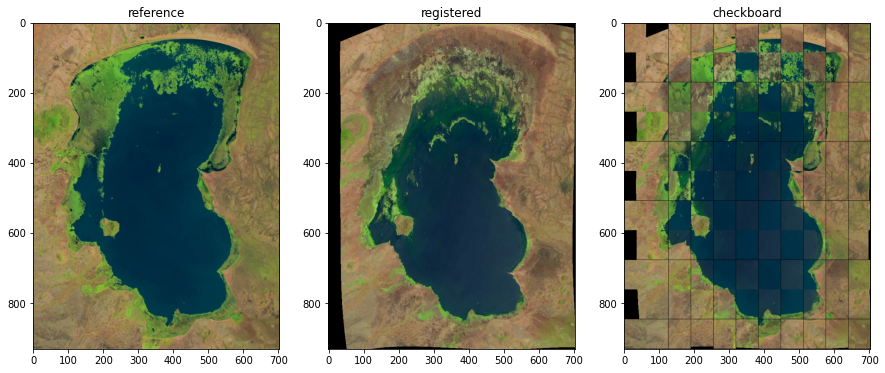

In [ ]:
# designate image path here
IX_path = '/content/cnn-registration/img/1a.jpg'
IY_path = '/content/cnn-registration/img/1b.jpg'

start = timeit.default_timer()


IX = cv2.imread(IX_path)
IY = cv2.imread(IY_path)

#initialize
reg = CNN()
#register
X, Y, Z = reg.register(IX, IY)
#generate regsitered image using TPS
registered = tps_warp(Y, Z, IY, IX.shape)
cb = checkboard(IX, registered, 11)

stop = timeit.default_timer()

print('Computation Time: {:.2f}s'.format(stop - start))

plt.subplot(131)
plt.title('reference')
plt.imshow(cv2.cvtColor(IX, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.title('registered')
plt.imshow(cv2.cvtColor(registered, cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.title('checkboard')
plt.imshow(cv2.cvtColor(cb, cv2.COLOR_BGR2RGB))

plt.show()

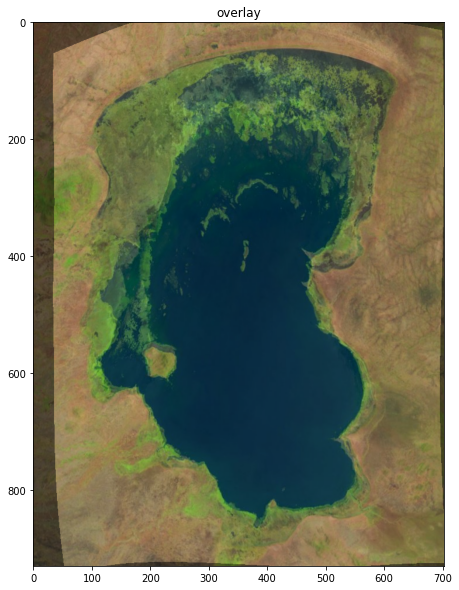

In [ ]:
plt.title('overlay')
plt.imshow(cv2.cvtColor(overlap(IX, registered, 0.5), cv2.COLOR_BGR2RGB))
plt.show()

## **Using RegNet Features**

### **Main**


RegNet architecture:
<div>
<img src="https://raw.githubusercontent.com/AdityaKane2001/regnety/main/images/regnety_architecture.png" width="500"/>
</div>

Y Block:
<div>
<img src="https://raw.githubusercontent.com/AdityaKane2001/regnety/main/images/YBlock.jpg" width="500"/>
</div>

In [ ]:
# initialize the regnet parameters
mean_imagenet=[0.485, 0.456, 0.406]
std_imagenet=[0.229, 0.224, 0.225]
regnet_parameters={
        'nf_regnet_b0':{
            'stage_depth': None,
            'stage_width': [40, 40, 80, 160, 960]
        },
        'nf_regnet_b1':{
            'stage_depth': None,
            'stage_width': [40, 40, 80, 160, 960]
        },
        'nf_regnet_b2':{
            'stage_depth': None,
            'stage_width': [40, 40, 88, 176, 1064]
        },
        'nf_regnet_b3':{
            'stage_depth': None,
            'stage_width': [40, 40, 96, 184, 1152]
        },
        'nf_regnet_b4':{
            'stage_depth': None,
            'stage_width': [48, 48, 112, 216, 1344]
        },
        'nf_regnet_b5':{
            'stage_depth': None,
            'stage_width': [64, 64, 128, 256, 1536]
        },
        'regnetx_002':{
            'stage_depth': [1, 3, 6, 6],
            'stage_width': [32, 24, 56, 152, 368]
        },
        'regnetx_004':{
            'stage_depth': [2, 4, 10, 2],
            'stage_width': [32, 32, 64, 160, 384]
        },
        'regnetx_006':{
            'stage_depth': [1, 2, 7, 12],
            'stage_width': [32, 48, 96, 240, 528]
        },
        'regnetx_008':{
            'stage_depth': [2, 6, 17, 2],
            'stage_width': [32, 64, 128, 288, 672]
        },
        'regnetx_016':{
            'stage_depth': None,
            'stage_width': [32, 72, 168, 408, 912]
        },
        'regnetx_032':{
            'stage_depth': None,
            'stage_width': [32, 96, 192, 432, 1008]
        },
        'regnetx_040':{
            'stage_depth': None,
            'stage_width': [32, 80, 240, 560, 1360]
        },
        'regnetx_064':{
            'stage_depth': None,
            'stage_width': [32, 168, 392, 784, 1624]
        },
        'regnetx_080':{
            'stage_depth': None,
            'stage_width': [32, 80, 240, 720, 1920]
        },
        'regnetx_120':{
            'stage_depth': None,
            'stage_width': [32, 224, 448, 896, 2240]
        },
        'regnetx_160':{
            'stage_depth': None,
            'stage_width': [32, 256, 512, 896, 2048]
        },
        'regnetx_320':{
            'stage_depth': None,
            'stage_width': [32, 336, 672, 1344, 2520]
        },
        'regnety_002':{
            'stage_depth': [1, 3, 5, 7],
            'stage_width': [32, 24, 56, 152, 368]
        },
        'regnety_004':{
            'stage_depth': [1, 3, 6, 6],
            'stage_width': [32, 48, 104, 208, 440]
        },
        'regnety_006':{
            'stage_depth': [1, 3, 7, 4],
            'stage_width': [32, 48, 112, 256, 608]
        },
        'regnety_008':{
            'stage_depth': [2, 6, 17, 4],
            'stage_width': [32, 64, 128, 320, 768]
        },
        'regnety_016':{
            'stage_depth': None,
            'stage_width': [32, 48, 120, 336, 888]
        },
        'regnety_032':{
            'stage_depth': None,
            'stage_width': [32, 72, 216, 576, 1512]
        },
        'regnety_040':{
            'stage_depth': None,
            'stage_width': [32, 128, 192, 512, 1088]
        },
        'regnety_064':{
            'stage_depth': None,
            'stage_width': [32, 144, 288, 576, 1296]
        },
        'regnety_080':{
            'stage_depth': None,
            'stage_width': [32, 168, 448, 896, 2016]
        },
        'regnety_120':{
            'stage_depth': None,
            'stage_width': [32, 224, 448, 896, 2240]
        },
        'regnety_160':{
            'stage_depth': None,
            'stage_width': [32, 224, 448, 1232, 3024]
        },
        'regnety_320':{
            'stage_depth': None,
            'stage_width': [32, 232, 696, 1392, 3712]
        },
    }

class RegistrationDCF(object):
    """
    Image registiration with Deep Convolutional Features.
    State-of-the-art RegNet neural networks were used to 
    infer deeply convolutional features.
    Parameters
    ----------
    model_name : str, default='regnetx_080'
        Pretrained RegNet models. (3 x H x W) All pre-trained models 
        expect input images normalized in the same way, i.e. mini-batches 
        of 3-channel RGB images of shape. Constructs a RegNet models 
        architecture from “Designing Network Design Spaces”.
    max_iter : int, default=200
        Maximum number of iterations of the registration process for a
        single run.
    tolerance : float, default=1e-2
        Relative tolerance with regards to expetations minimization of the 
        difference in the two images.
    freq : int, default=5
        Dynamic inlier selection iteration number. Update the selection of 
        inliers in every freq iterations. Points selected as inliers guide 
        the movement of point locations whereas outliers are moved coherently.
    epsilon : float, default=0.5
        ϵ is a hyper-parameter valued in [0, 1] which should be designated 
        according to our confidence of the inlier selection to be accurate.  
    omega : float, default=0.5
        Outlier (within detected features) balancing weight.
    beta : float, defult=2.0
        Gaussian radial basis variance β.
    lambd : float, default=0.5
        Same as the omega. Lambda  is initialize as second transformation 
        coefficient omega (w) is initialized to a matrix of all zeros. 
    height : int, default=224
        Image height.
    width : int, default=224
        Image width.
    verbose : bool, default=False
        If true, it print some information on the screen after registration.
    """
    def __init__(self, model_name='regnetx_080', max_iter = 200, 
                 tolerance = 1e-2, freq = 5, epsilon = 0.5, 
                 omega = 0.5, beta = 2.0, lambd = 0.5, 
                 height = 224, width = 224, verbose=False):
        
        self.model_name = model_name
        self.max_iter = max_iter
        self.tolerance = tolerance
        # k in the paper
        self.freq = freq 
        self.epsilon = epsilon
        self.omega = omega
        self.beta = beta
        self.lambd = lambd

        self.height = height
        self.width = width

        self.verbose = verbose

        self.SC = ShapeContext()

    def _check_params(self):
            # model_name
            if self.model_name not in regnet_parameters.keys():
                raise ValueError(
                    f"model_name should be in {regnet_parameters.keys()}," 
                    f"but got {self.model_name} instead.")
            else:
                self.model = timm.create_model(self.model_name, features_only=True, pretrained=True) 
                self._map = regnet_parameters[self.model_name]['stage_width']

            # max_iter
            if self.max_iter <= 0:
                raise ValueError(
                    f"max_iter should be > 0, got {self.max_iter} instead.")
                
            # epsilon
            if not self.epsilon >= 0.0 and self.epsilon <= 1.0:
                raise ValueError(
                    f"epsilon should be >= 0 and <= 1, got {self.epsilon} instead.")
            
            # omega
            if not self.omega >= 0.0 and self.omega <= 1.0:
                raise ValueError(
                    f"omega should be >= 0 and <= 1, got {self.omega} instead.")
                
            # lambda
            if not self.lambd >= 0.0 and self.lambd <= 1.0:
                raise ValueError(
                    f"lambd should be >= 0 and <= 1, got {self.lambd} instead.")

            # shape
            if self.height != self.width:
                raise ValueError(
                    f"height={self.height} should be == "
                    f"width={self.width}.")
            else:
                self.shape = np.array([float(self.height), float(self.width)])

    def get_image(self, image_path, shape=None):
        """
        Dirs of the image to be processed.
        Parameters
        ----------
        image_path : str
            Image path.
        shape : tuple(int, int), default=None
            The size of the image to resize.
        Return
        ----------
        image : torch.float32
            The read image is returned as torch.tensor.
        """
        image = cv2.imread(image_path)
        if shape is not None:
            image = cv2.resize(image, shape)
        normalize = transforms.Normalize(mean=mean_imagenet,
                                               std=std_imagenet) 
        transform_norm = transforms.Compose([
            normalize
        ])
        image = image.reshape(1, 3, image.shape[0], image.shape[1])
        image = torch.tensor(image, dtype=torch.float32)
        image = transform_norm(image)
        
        return image

    def register(self, IX, IY):
        """
        The objective of the algorithm is to transform a sensed image IY so 
        that it is aligned to a reference image IX. Detect a feature point 
        set X from the reference image and a feature point set Y from the 
        sensed image. Next step is a expectation maximization (EM) based 
        procedure to obtain the transformed locations of Y , namely Z. 
        Y and Z are then used to solve a thin plate spline (TPS) interpolation 
        for image transformation. 
        Parameters
        ----------
        IX : str
            Reference image path.
        IY : str
            Image path to register.
        Return
        ----------
        X : nd.array
            Detected feature point set X from the reference image.
        Y : nd.array
            Detected feature point set Y from the sensed image.
        Z : nd.array
            Transformed locations of Y.
        """

        # check parameters
        self._check_params()

        omega = self.omega
        lambd = self.lambd

        IX = self.get_image(IX, (self.height, self.width))
        IY = self.get_image(IY, (self.height, self.width))

        Xscale = 1.0 * np.array(IX.shape[:2]) / self.shape
        Yscale = 1.0 * np.array(IY.shape[:2]) / self.shape

        features_x = self.model(IX)
        features_y = self.model(IY)

        # flattening
        DX1, DY1 = np.reshape(features_x[2][0].detach().numpy(), [-1, self._map[2]]), \
                   np.reshape(features_y[2][0].detach().numpy(), [-1, self._map[2]])
        DX2, DY2 = np.reshape(features_x[3][0].detach().numpy(), [-1, self._map[3]]), \
                   np.reshape(features_y[3][0].detach().numpy(), [-1, self._map[3]]) 
        DX3, DY3 = np.reshape(features_x[4][0].detach().numpy(), [-1, self._map[4]]), \
                   np.reshape(features_y[4][0].detach().numpy(), [-1, self._map[4]]) 

        del features_x, features_y

        # normalization
        DX1, DY1 = DX1 / np.std(DX1), DY1 / np.std(DY1)
        DX2, DY2 = DX2 / np.std(DX2), DY2 / np.std(DY2)
        DX3, DY3 = DX3 / np.std(DX3), DY3 / np.std(DY3)

        # compute feature space distance
        PD1 = pairwise_distance(DX1, DY1)
        PD2 = pd_expand(pairwise_distance(DX2, DY2), 2)
        PD3 = pd_expand(pairwise_distance(DX3, DY3), 4)
        PD = 1.414 * PD1 + PD2 + PD3

        del DX1, DY1, DX2, DY2, DX3, DY3, PD1, PD2, PD3

        seq = np.array([[i, j] for i in range(28) for j in range(28)], dtype='int32')

        X = np.array(seq, dtype='float32') * 8.0 + 4.0
        Y = np.array(seq, dtype='float32') * 8.0 + 4.0

        # normalize empty feature prematches
        X = (X - 112.0) / 224.0
        Y = (Y - 112.0) / 224.0

        # prematch and select points
        C_all, quality = match(PD)
        tau_max = np.max(quality)
        while np.where(quality >= tau_max)[0].shape[0] <= 128: tau_max -= 0.01

        C = C_all[np.where(quality >= tau_max)]
        cnt = C.shape[0]

        # select prematched feature points
        X, Y = X[C[:, 1]], Y[C[:, 0]]
        PD = PD[np.repeat(np.reshape(C[:, 1], [cnt, 1]), cnt, axis=1),
                np.repeat(np.reshape(C[:, 0], [1, cnt]), cnt, axis=0)]

        N = X.shape[0]
        M = X.shape[0]
        assert M == N

        # precalculation of feature match
        C_all, quality = match(PD)

        # compute \hat{\theta} and \delta
        tau_min = np.min(quality)
        tau_max = np.max(quality)

        while np.where(quality >= tau_max)[0].shape[0] <= 0.5 * cnt: tau_max -= 0.01
        tau = tau_max
        delta = (tau_max - tau_min) / 10.0

        SCX = self.SC.compute(X)

        # initialization
        Z = Y.copy()
        GRB = gaussian_radial_basis(Y, self.beta)
        A = np.zeros([M, 2])
        sigma2 = init_sigma2(X, Y)

        Pr = None

        Q = 0
        dQ = float('Inf')
        itr = 1

        # registration process
        while itr < self.max_iter and abs(dQ) > self.tolerance and sigma2 > 1e-4:
            Z_old = Z.copy()
            Q_old = Q

            # for every k iterations
            if (itr - 1) % self.freq == 0:
                # compute C^{conv}_{\theta}
                C = C_all[np.where(quality >= tau)]
                Lt = PD[C[:, 0], C[:, 1]]
                maxLt = np.max(Lt)
                if maxLt > 0: Lt = Lt / maxLt
                L = np.ones([M, N])
                L[C[:, 0], C[:, 1]] = Lt

                # compute C^{geo}_{\theta}
                SCZ = self.SC.compute(Z)
                SC_cost = self.SC.cost(SCZ, SCX)

                # compute C
                L = L * SC_cost

                # linear assignment
                C = lapjv(L)[1]

                # prior probability matrix
                Pr = np.ones_like(PD) * (1.0 - self.epsilon) / N
                Pr[np.arange(C.shape[0]), C] = 1.0
                Pr = Pr / np.sum(Pr, axis=0)

                tau = tau - delta
                if tau < tau_min: tau = tau_min

            # compute minimization
            Po, P1, Np, tmp, Q = compute(X, Y, Z_old, Pr, sigma2, omega)
            Q = Q + lambd / 2 * np.trace(np.dot(np.dot(A.transpose(), GRB), A))

            # update variables
            dP = np.diag(P1)
            t1 = np.dot(dP, GRB) + lambd * sigma2 * np.eye(M)
            t2 = np.dot(Po, X) - np.dot(dP, Y)
            A = np.dot(np.linalg.inv(t1), t2)
            sigma2 = tmp / (2.0 * Np)
            omega = 1 - (Np / N)
            if omega > 0.99: omega = 0.99
            if omega < 0.01: omega = 0.01
            Z = Y + np.dot(GRB, A)
            lambd = lambd * 0.95
            if lambd < 0.1: lambd = 0.1

            dQ = Q - Q_old
            itr = itr + 1
        
        X = ((X * 224.0) + 112.0) * Xscale 
        Y = ((Y * 224.0) + 112.0) * Yscale
        Z = ((Z * 224.0) + 112.0) * Xscale
        X, Y, Z = X * self._map[-1], Y * self._map[-1], Z * self._map[-1]

        if self.verbose:
            print('Finished! iteration num: %d, Q: %d, tau: %d' % (itr, Q, tau))

        return X, Y, Z

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_080-7c7fcab1.pth" to /root/.cache/torch/hub/checkpoints/regnetx_080-7c7fcab1.pth


Finished! iteration num: 19, Q: -865, tau: 1
hi = 84.54545454545455 , wi = 63.90909090909091
outshape = (930, 703, 3)
Computation Time: 35.45s


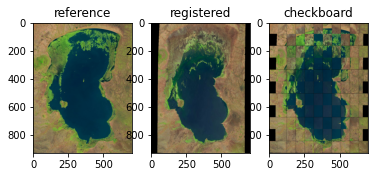

In [ ]:
# designate image path here
IX_path = '/content/cnn-registration/img/1a.jpg'
IY_path = '/content/cnn-registration/img/1b.jpg'

start = timeit.default_timer()

IX = cv2.imread(IX_path)
IY = cv2.imread(IY_path)

# initialize
reg = RegistrationDCF('regnetx_080', verbose=True) 
# register
X, Y, Z = reg.register(IX_path, IY_path)
# generate regsitered image using TPS
registered = tps_warp(Y, Z, IY, IX.shape)
cb = checkboard(IX, registered, 11)

stop = timeit.default_timer()

print('Computation Time: {:.2f}s'.format(stop - start))

plt.subplot(131)
plt.title('reference')
plt.imshow(cv2.cvtColor(IX, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.title('registered')
plt.imshow(cv2.cvtColor(registered, cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.title('checkboard')
plt.imshow(cv2.cvtColor(cb, cv2.COLOR_BGR2RGB))

plt.show()

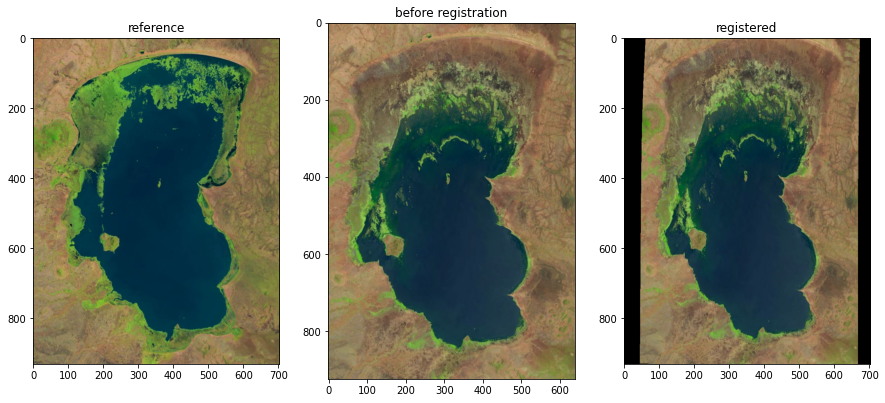

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.subplot(131)
plt.title('reference')
plt.imshow(cv2.cvtColor(IX, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.title('before registration')
plt.imshow(cv2.cvtColor(IY, cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.title('registered')
plt.imshow(cv2.cvtColor(registered, cv2.COLOR_BGR2RGB))

plt.show()

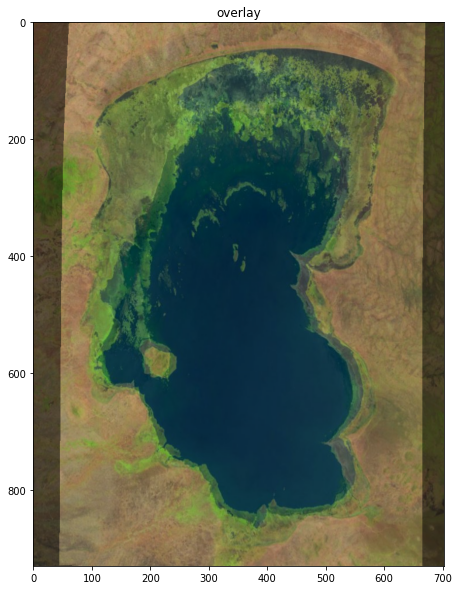

In [ ]:
plt.title('overlay')
plt.imshow(cv2.cvtColor(overlap(IX, registered, 0.5), cv2.COLOR_BGR2RGB))
plt.show()

# **References**



*   [Pretrained RegNet in Tensorflow](https://github.com/AdityaKane2001/regnety#usage)
*   [RegNet Tensorflow](https://github.com/QiaoranC/tf_ResNeSt_RegNet_model)
*   [RegNet pyTorch](https://github.com/d-li14/regnet.pytorch)
*   [RegNet official pyTorch](https://pytorch.org/vision/master/_modules/torchvision/models/regnet.html)
*   [RegNet Medium](https://medium.com/visionwizard/simple-powerful-and-fast-regnet-architecture-from-facebook-ai-research-6bbc8818fb44)
*   [Histology Cima Dataset](https://www.kaggle.com/jirkaborovec/histology-cima-dataset)
*   [Histology Landmarks](https://github.com/Borda/dataset-histology-landmarks)
*   [Image Super Resolution Dataset](https://www.kaggle.com/yashchoudhary/realsr-v3)
*   [Retinal Image Dataset](https://www.kaggle.com/andrewmvd/drive-digital-retinal-images-for-vessel-extraction)
*   [Satellite Image Dataset](https://www.kaggle.com/c/draper-satellite-image-chronology/overview)
*   [EDA for Satellite Images](https://www.kaggle.com/bkamphaus/exploratory-image-analysis)
*   [Small UAV Dataset](https://github.com/yyangynu/SUIRD)
*   [Retina Fundus Dataset](https://www.kaggle.com/andrewmvd/fundus-image-registration)
